In [2]:
import deepdish as dd
import json
import numpy as np
import tensorflow as tf
import pandas as pd
import shap
import pyfaidx
import shutil
import os
import TF_score
from tqdm import tqdm

import shap
from collections import OrderedDict
import modisco
from deeplift.dinuc_shuffle import dinuc_shuffle

In [1]:
# disable eager execution so shap deep explainer wont break
tf.compat.v1.disable_eager_execution()

NameError: name 'tf' is not defined

In [ ]:
def dna_to_one_hot(seqs):
    """
    Converts a list of DNA ("ACGT") sequences to one-hot encodings, where the
    position of 1s is ordered alphabetically by "ACGT". `seqs` must be a list
    of N strings, where every string is the same length L. Returns an N x L x 4
    NumPy array of one-hot encodings, in the same order as the input sequences.
    All bases will be converted to upper-case prior to performing the encoding.
    Any bases that are not "ACGT" will be given an encoding of all 0s.
    """
    seq_len = len(seqs[0])
    assert np.all(np.array([len(s) for s in seqs]) == seq_len)

    # Join all sequences together into one long string, all uppercase
    seq_concat = "".join(seqs).upper() + "ACGT"
    # Add one example of each base, so np.unique doesn't miss indices later

    one_hot_map = np.identity(5)[:, :-1].astype(np.int8)

    # Convert string into array of ASCII character codes;
    base_vals = np.frombuffer(bytearray(seq_concat, "utf8"), dtype=np.int8)

    # Anything that's not an A, C, G, or T gets assigned a higher code
    base_vals[~np.isin(base_vals, np.array([65, 67, 71, 84]))] = 85

    # Convert the codes into indices in [0, 4], in ascending order by code
    _, base_inds = np.unique(base_vals, return_inverse=True)

    # Get the one-hot encoding for those indices, and reshape back to separate
    return one_hot_map[base_inds[:-4]].reshape((len(seqs), seq_len, 4))

def get_seq(peaks_df, genome, width):
    """
    Same as get_cts, but fetches sequence from a given genome.
    """
    vals = []
    peaks_used = []
    for i, r in peaks_df.iterrows():
        sequence = str(genome[r[0]][(r[1] - width//2):(r[1] + width//2)])
        if len(sequence) == width:
            vals.append(sequence)
            peaks_used.append(True)
        else:
            peaks_used.append(False)

    return dna_to_one_hot(vals)


def get_weightedsum_meannormed_logits(model):
    # Assumes the 0 task track is for profile
    # See Google slide deck for explanations
    # We meannorm as per section titled 
    # "Adjustments for Softmax Layers" in the DeepLIFT paper
    meannormed_logits = (model.outputs[0] - \
                         tf.reduce_mean(model.outputs[0], axis=1)[:, None])

    # 'stop_gradient' will prevent importance from being propagated
    # through this operation; we do this because we just want to treat
    # the post-softmax probabilities as 'weights' on the different 
    # logits, without having the network explain how the probabilities
    # themselves were derived. Could be worth contrasting explanations
    # derived with and without stop_gradient enabled...
    stopgrad_meannormed_logits = tf.stop_gradient(meannormed_logits)
    softmax_out = tf.nn.softmax(stopgrad_meannormed_logits, axis=1)
    
    # Weight the logits according to the softmax probabilities, take
    # the sum for each example. This mirrors what was done for the
    # bpnet paper.
    weightedsum_meannormed_logits = tf.reduce_sum(softmax_out * \
                                                  meannormed_logits,
                                                  axis=1)
    
    return weightedsum_meannormed_logits

def shuffle_several_times(s,numshuffles=20):
    if len(s)==2:
        return [np.array([dinuc_shuffle(s[0]) for i in range(numshuffles)]),
                np.array([s[1] for i in range(numshuffles)])]
    else:
        return [np.array([dinuc_shuffle(s[0]) for i in range(numshuffles)])]

def combine_mult_and_diffref(mult, orig_inp, bg_data):
    to_return = []
    
    for l in [0]:
        projected_hypothetical_contribs = \
            np.zeros_like(bg_data[l]).astype("float")
        assert len(orig_inp[l].shape)==2
        
        # At each position in the input sequence, we iterate over the
        # one-hot encoding possibilities (eg: for genomic sequence, 
        # this is ACGT i.e. 1000, 0100, 0010 and 0001) and compute the
        # hypothetical difference-from-reference in each case. We then 
        # multiply the hypothetical differences-from-reference with 
        # the multipliers to get the hypothetical contributions. For 
        # each of the one-hot encoding possibilities, the hypothetical
        # contributions are then summed across the ACGT axis to 
        # estimate the total hypothetical contribution of each 
        # position. This per-position hypothetical contribution is then
        # assigned ("projected") onto whichever base was present in the
        # hypothetical sequence. The reason this is a fast estimate of
        # what the importance scores *would* look like if different 
        # bases were present in the underlying sequence is that the
        # multipliers are computed once using the original sequence, 
        # and are not computed again for each hypothetical sequence.
        for i in range(orig_inp[l].shape[-1]):
            hypothetical_input = np.zeros_like(orig_inp[l]).astype("float")
            hypothetical_input[:, i] = 1.0
            hypothetical_difference_from_reference = \
                (hypothetical_input[None, :, :] - bg_data[l])
            hypothetical_contribs = hypothetical_difference_from_reference * \
                                    mult[l]
            projected_hypothetical_contribs[:, :, i] = \
                np.sum(hypothetical_contribs, axis=-1) 
            
        to_return.append(np.mean(projected_hypothetical_contribs,axis=0))

    if len(orig_inp)>1:
        to_return.append(np.zeros_like(orig_inp[1]))
    
    return to_return

def generate_shap_dict(seqs, scores):
    assert(seqs.shape==scores.shape)
    assert(seqs.shape[2]==4)

    # construct a dictionary for the raw shap scores and the
    # the projected shap scores
    # MODISCO workflow expects one hot sequences with shape (None,4,inputlen)
    d = {
            'raw': {'seq': np.transpose(seqs, (0, 2, 1)).astype(np.int8)},
            'shap': {'seq': np.transpose(scores, (0, 2, 1)).astype(np.float16)},
            'projected_shap': {'seq': np.transpose(seqs*scores, (0, 2, 1)).astype(np.float16)}
        }

    return d


In [ ]:
model = TF_score.load_model_wrapper("doubletRemoved_models/C1_chrombpnet_nobias.h5")



# seqs, output_prefix, profile_or_counts

In [26]:
genome = pyfaidx.Fasta("../genomes/hg38.fa")
regions_df = pd.read_csv('training_data/peaks/C1_peaks.bed', sep='\t', header=None).iloc[:5000]

In [27]:
regions_df.to_csv('sample_peaks.bed')

In [28]:
seqs = get_seq(regions_df, genome, 2114)

In [29]:
genome.close()

In [30]:
profile_model_input = model.input
profile_input = seqs

In [31]:
weightedsum_meannormed_logits = get_weightedsum_meannormed_logits(model)

In [32]:
profile_model_profile_explainer = shap.explainers.deep.TFDeepExplainer(
    (profile_model_input, weightedsum_meannormed_logits),
    shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)

In [33]:
profile_shap_scores = profile_model_profile_explainer.shap_values(
    profile_input, progress_message=100)

Done 0 examples of 5000
Done 100 examples of 5000
Done 200 examples of 5000
Done 300 examples of 5000
Done 400 examples of 5000
Done 500 examples of 5000
Done 600 examples of 5000
Done 700 examples of 5000
Done 800 examples of 5000
Done 900 examples of 5000
Done 1000 examples of 5000
Done 1100 examples of 5000
Done 1200 examples of 5000
Done 1300 examples of 5000
Done 1400 examples of 5000
Done 1500 examples of 5000
Done 1600 examples of 5000
Done 1700 examples of 5000
Done 1800 examples of 5000
Done 1900 examples of 5000
Done 2000 examples of 5000
Done 2100 examples of 5000
Done 2200 examples of 5000
Done 2300 examples of 5000
Done 2400 examples of 5000
Done 2500 examples of 5000
Done 2600 examples of 5000
Done 2700 examples of 5000
Done 2800 examples of 5000
Done 2900 examples of 5000
Done 3000 examples of 5000
Done 3100 examples of 5000
Done 3200 examples of 5000
Done 3300 examples of 5000
Done 3400 examples of 5000
Done 3500 examples of 5000
Done 3600 examples of 5000
Done 3700 exa

In [34]:
profile_scores_dict = generate_shap_dict(seqs, profile_shap_scores)

In [35]:
np.savez('ohe.npz', profile_scores_dict['raw']['seq'])

In [36]:
np.savez('attr.npz', profile_scores_dict['shap']['seq'])

In [63]:
# save the dictionary in HDF5 formnat
print("Saving 'profile' scores")
output_prefix = "test"
scores_path = f"{output_prefix}.profile_scores.h5"
dd.io.save(scores_path,
            profile_scores_dict,
            compression='blosc')


Saving 'profile' scores


In [64]:
output_dir = '.'
save_path = os.path.join(output_dir,'modisco_results_allChroms_profile.hdf5')
seqlet_path = os.path.join(output_dir,'seqlets_profile.txt')

In [65]:
scores = dd.io.load(scores_path)


In [66]:
crop = 1000

In [67]:
shap_scores_seq = []
proj_shap_scores_seq = []
one_hot_seqs = [] 
center = scores['shap']['seq'].shape[-1]//2
start = center - crop//2
end = center + crop//2
for i in scores['shap']['seq']:
    shap_scores_seq.append(i[:,start:end].transpose())


for i in scores['projected_shap']['seq']:
    proj_shap_scores_seq.append(i[:,start:end].transpose())

for i in scores['raw']['seq']:
    one_hot_seqs.append(i[:,start:end].transpose())

In [68]:
tasks = ['task0']
task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

onehot_data = one_hot_seqs
task_to_scores['task0']  = proj_shap_scores_seq
task_to_hyp_scores['task0']  = shap_scores_seq

In [69]:
max_seqlets = 50000

MEMORY 2.79035904
On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= -0.00048827743530273436
Computing threshold
For increasing = True , the minimum IR precision was 0.47004155200366776 occurring at 0.0 implying a frac_neg of 0.8869403889697421
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.0 occurring at -1.685609523387839e-06 implying a frac_neg of 1.00000010000001e-07
To be conservative, adjusted frac neg is 0.95
Thresholds from null dist were -0.07861328125  and  0.075439453125 with frac passing 0.013730886850152906
Passing windows frac was 0.013730886850152906 , which is below  0.03 ; adjusting
Final raw thresholds are -0.0570068359375  and  0.0570068359375
Final transformed thresholds are -0.9699694189602447  and  0.9699694189602447


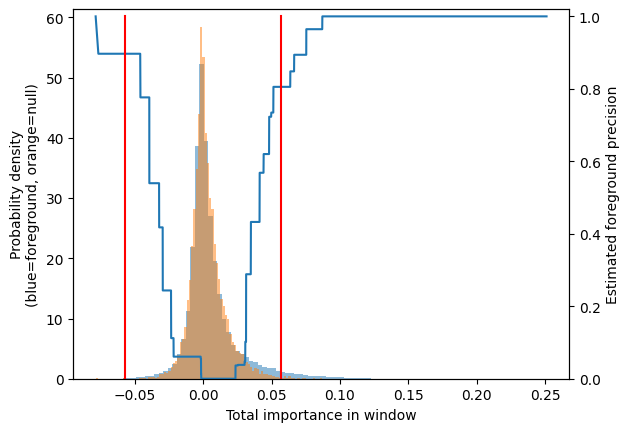

Got 216 coords
After resolving overlaps, got 216 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9698694189602447
MEMORY 2.793562112
216 identified in total
1 activity patterns with support >= 100 out of 2 possible patterns
Metacluster sizes:  [212]
Idx to activities:  {0: '1'}
MEMORY 2.793562112
On metacluster 0
Metacluster size 212
Relevant tasks:  ('task0',)
Relevant signs:  (1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 212
(Round 1) Computing coarse affmat
MEMORY 2.79359488
Beginning embedding computation
MEMORY 2.79359488
At the beginning of embedding call
MEMORY 2.79359488
before computing embeddings fwd
MEMORY 2.79359488


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   21.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   46.0s
[Parallel(n_jobs=10)]: Done 212 out of 212 | elapsed:   51.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


after computing embeddings fwd
MEMORY 2.801475584


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   27.0s
[Parallel(n_jobs=10)]: Done 212 out of 212 | elapsed:   31.9s finished


after computing embeddings rev
MEMORY 2.810085376
before computing sparse embeddings fwd
MEMORY 2.810085376
Constructing csr matrix...
csr matrix made in 0.12185192108154297 s
after computing sparse embeddings fwd
MEMORY 2.810126336
before computing sparse embeddings rev
MEMORY 2.810126336
Constructing csr matrix...
csr matrix made in 0.03655719757080078 s
after computing sparse embeddings rev
MEMORY 2.810175488
Finished embedding computation in 83.66 s
MEMORY 2.800738304
Starting affinity matrix computations
MEMORY 2.800738304
Batching in slices of size 212


100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

Finished affinity matrix computations in 1.48 s
MEMORY 2.80082432


(Round 1) Computed coarse affmat
MEMORY 2.80082432
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 2.80082432
Launching nearest neighbors affmat calculation job
MEMORY 2.800832512
Parallel runs completed
MEMORY 2.80864768
Job completed in: 18.33 s
MEMORY 2.808676352
Launching nearest neighbors affmat calculation job
MEMORY 2.808676352
Parallel runs completed
MEMORY 2.812694528
Job completed in: 18.17 s
MEMORY 2.812706816
(Round 1) Computed affinity matrix on nearest neighbors in 36.78 s
MEMORY 2.812706816
Filtered down to 212 of 212
(Round 1) Retained 212 rows out of 212 after filtering
MEMORY 2.812772352
(Round 1) Computing density adapted affmat
MEMORY 2.812796928
Symmetrizing nearest neighbors
Computing betas for density adaptation
Computing normalizing denominators
(Round 1) Computing clustering
MEMORY 2.813636608
Beginning preprocessing + Leiden
Affmat shape: 212


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


RuntimeError: ----
ERROR:
Traceback (most recent call last):
  File "/gstore/home/toneyans/anaconda3/envs/cbp/lib/python3.9/site-packages/modisco/cluster/run_leiden", line 5, in <module>
    import igraph as ig
ModuleNotFoundError: No module named 'igraph'

----
STDOUT:


In [70]:
tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    min_metacluster_size_frac=0.0001,
                    max_seqlets_per_metacluster=max_seqlets,
                    sliding_window_size=20,
                    flank_size=5,
                    target_seqlet_fdr=0.05,
                    seqlets_to_patterns_factory=modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        n_cores=10,
                        trim_to_window_size=20,
                        initial_flank_to_add=5,
                        final_min_cluster_size=20))(task_names=["task0"],
                            contrib_scores=task_to_scores,
                            hypothetical_contribs=task_to_hyp_scores,
                            one_hot=onehot_data)